In [1]:
import os
import sys
from tempfile import gettempdir

sys.path.append('../')

import matplotlib
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numba
import numpy as np
import scipy.io as scio
from numpy.fft import fft, fft2, fftshift, ifft, ifft2, ifftshift

from kwave.kmedium import kWaveMedium
from kwave.ksource import kSource
from kwave.kspaceFirstOrder2D import kspaceFirstOrder2DC
from kwave.ktransducer import *
from kwave.utils import *
from utils.data import load_mat, save_mat
from utils.simulations import get_water_SoS

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

data_path = '../data/'

### Load Initial Pressure

Text(0.5, 1.0, 'Initial Pressure')

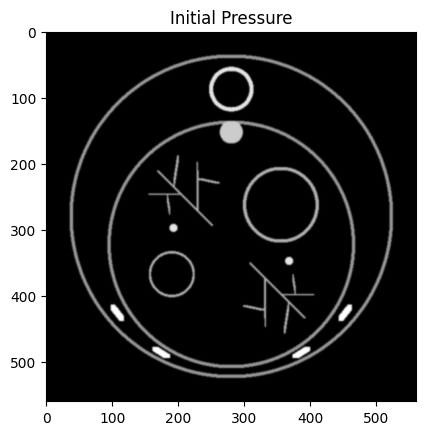

In [2]:
IP_img = load_mat(os.path.join(data_path, 'IP.mat'))

plt.imshow(IP_img, cmap='gray')
plt.title('Initial Pressure')

Pad the image to the size of the computaional grid.

In [3]:
pad_x, pad_y = 2544, 2544 # 2024, 2024
IP_pad = np.zeros((pad_x, pad_y))
pad_start, pad_end = (pad_x-IP_img.shape[0]) // 2, (pad_x+IP_img.shape[1]) // 2
IP_pad[pad_start:pad_end, pad_start:pad_end] = IP_img

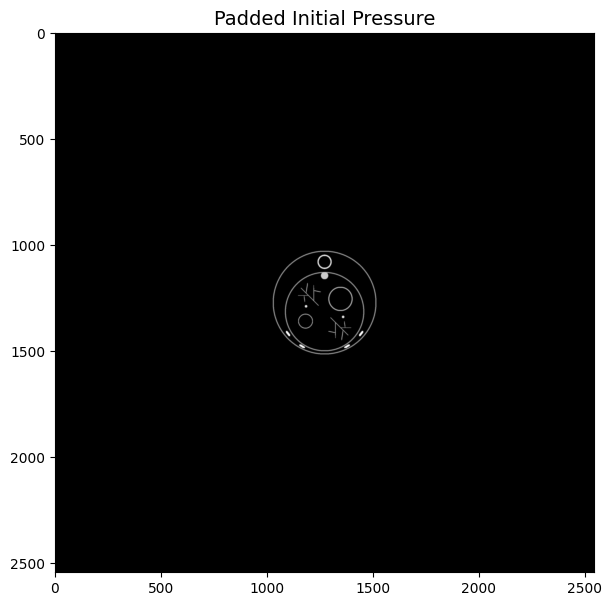

In [4]:
plt.figure(figsize=(7,7))
plt.title('Padded Initial Pressure', fontsize=14)
plt.imshow(IP_pad, cmap='gray')

In [5]:
pathname = gettempdir()

PML_size = 8                                # Size of the PML in grid points.
Nx, Ny = IP_pad.shape
R_ring = 0.05                               # Radius of the ring array [m].
dx, dy = 4.e-5, 4.e-5                       # Grid point spacing in the y direction [m].
T_sample = 1/80e6                           # Sample time step [s].

N_transducer = 512                          # Number of transducers in ring array.
center_pos = [0, 0]
arc_angle = 2 * np.pi
kgrid = kWaveGrid([Nx, Ny], [dx, dy])

Define SoS distribution.

Load speed of sound distribution.

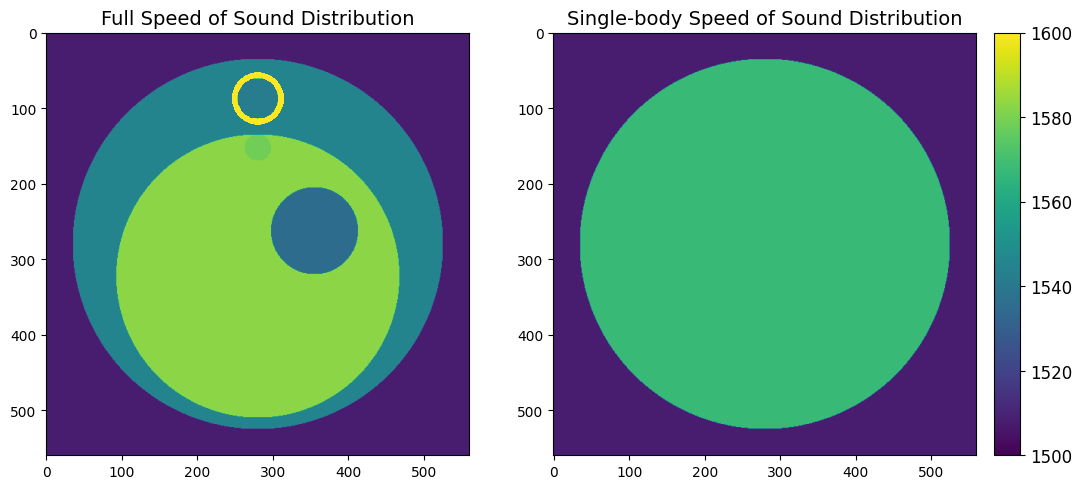

In [6]:
SoS = load_mat(os.path.join(data_path, 'SoS.mat'))
SoS_SB = load_mat(os.path.join(data_path, 'SoS_SB.mat'))

fig = plt.figure(figsize=(12, 6))
norm = Normalize(vmax=1600, vmin=1500)
ax = plt.subplot(1,2,1)
plt.title('Full Speed of Sound Distribution', fontsize=14)
plt.imshow(SoS, norm=norm)

ax = plt.subplot(1,2,2)
plt.title('Single-body Speed of Sound Distribution', fontsize=14)
plt.imshow(SoS_SB, norm=norm)
cax = fig.add_axes([ax.get_position().x1+0.015, ax.get_position().y0, 0.022, ax.get_position().height])
cb = plt.colorbar(cax=cax, norm=norm)
cb.ax.tick_params(labelsize=13)
cb.ax.set_yticks([1500, 1520, 1540, 1560, 1580, 1600])
plt.tick_params(labelsize=12)

In [7]:
v0, v1, v2 = get_water_SoS(29.5), 1600, 1650             # SoS of the two circles. [m/s]

XX, YY = np.meshgrid(kgrid.x_vec.copy(), kgrid.y_vec.copy())
rou = 1000 # Density.

In [8]:
SoS_pad = np.ones((pad_x, pad_y)) * v0
SoS_pad[pad_start:pad_end, pad_start:pad_end] = SoS
SoS_SB_pad = np.ones((pad_x, pad_y)) * v0
SoS_SB_pad[pad_start:pad_end, pad_start:pad_end] = SoS_SB

medium = kWaveMedium(sound_speed=SoS_pad, sound_speed_ref=v0, density=rou)
medium_SB = kWaveMedium(sound_speed=SoS_SB_pad, sound_speed_ref=v0, density=rou)
medium_uniform = kWaveMedium(sound_speed=v0, sound_speed_ref=v0, density=rou)

Draw the SoS distribution and the size of image.

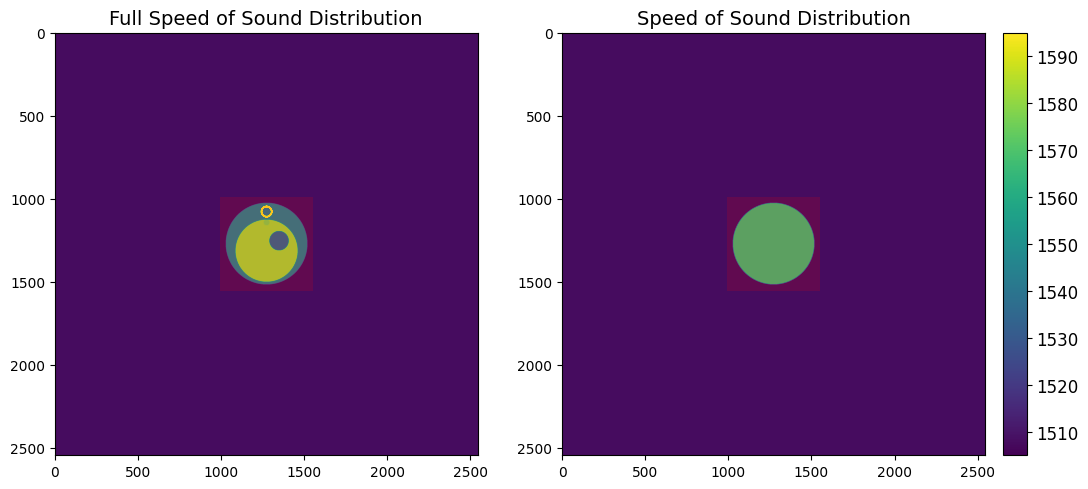

In [9]:
fig = plt.figure(figsize=(12, 6))
norm = matplotlib.colors.Normalize(vmax=1595, vmin=1505)
ax = plt.subplot(1,2,1)
plt.imshow(SoS_pad, norm=norm)
plt.title('Full Speed of Sound Distribution', fontsize=14)
left, bottom, width, height = (pad_x//2-280, pad_y//2-280, 560, 560)
image = mpatches.Rectangle((left,bottom), width, height, alpha=0.15, facecolor="red")
plt.gca().add_patch(image) # Show the size of image.

ax = plt.subplot(1,2,2)
plt.imshow(SoS_SB_pad, norm=norm)
plt.title('Speed of Sound Distribution', fontsize=14)
left, bottom, width, height = (pad_x//2-280, pad_y//2-280, 560, 560)
image = mpatches.Rectangle((left,bottom), width, height, alpha=0.15, facecolor="red")
plt.gca().add_patch(image) # Show the size of image.
cax = fig.add_axes([ax.get_position().x1+0.015, ax.get_position().y0, 0.02, ax.get_position().height])
cb = plt.colorbar(cax=cax)
cb.ax.tick_params(labelsize=13)
plt.tick_params(labelsize=12)

### K-wave Forward Simulation

In [ ]:
source = kSource()
source.p0 = IP_pad

# Smooth the initial pressure distribution and restore the magnitude.
source.p0 = smooth(source.p0, True)

cart_sensor_mask = makeCartCircle(R_ring, N_transducer, center_pos, arc_angle)
sensor = kSensor(cart_sensor_mask) # Assign to sensor structure.

# Create the time array.
kgrid.makeTime(medium.sound_speed)
kgrid.setTime(8000, T_sample/2) 

# Set the input arguements: force the PML to be outside the computational grid switch off p0 smoothing within kspaceFirstOrder2D.
input_args = {
    'PMLInside': False,
    'PMLSize': PML_size,
    'Smooth': False,
    'SaveToDisk': os.path.join(pathname, 'example_input.h5'),
    'SaveToDiskExit': False,
}

# Run the simulation.
sensor_data = kspaceFirstOrder2DC(**{
    'medium': medium,
    'kgrid': kgrid,
    'source': source,
    'sensor': sensor,
    **input_args
})

print(sensor_data.shape)

  start time: 15-Mar-2024-13-28-57
Running k-Wave simulation...
  start time: 15-Mar-2024-13-28-57
  reference sound speed:  1508.0046878478038 m/s
  reference sound speed:  1508.0046878478038 m/s
  dt:  6.25ns , t_end: 49.9938us , time steps: 8000
  input grid size: 2544 by 2544 grid points (101.76 by 101.76 m)
  maximum supported frequency:  18.8501M Hz
  expanding computational grid...
  computational grid size: 2560 by 2560 grid points
  precomputation completed in  0.19816945493221283 s
  saving input files to disk...


Downsample the sensor data.

In [ ]:
sensor_data = sensor_data[:, ::4]

In [ ]:
def reorder_binary_sensor_data(sensor_data, sensor, kgrid, PML_size):

    x_sensor = kgrid.x[sensor.mask[PML_size:-PML_size,PML_size:-PML_size] == 1]
    y_sensor = kgrid.y[sensor.mask[PML_size:-PML_size,PML_size:-PML_size] == 1]
    
    angle = np.arctan2(-x_sensor, -y_sensor)
    angle[angle < 0] = 2 * np.pi + angle[angle < 0]
    reorder_index = np.argsort(angle)
    
    return sensor_data[reorder_index]

sensor_data = reorder_binary_sensor_data(sensor_data, sensor, kgrid, PML_size)

Apply transducer effect.

In [ ]:
def transducer_response(sensor_data):
    sensor_data = np.append(sensor_data, np.zeros((sensor_data.shape[0],1)), axis=1)
    return -2 * (sensor_data[:,1:] - sensor_data[:,:-1])

sinogram = transducer_response(sensor_data)

In [ ]:
data = {'sinogram': sinogram.swapaxes(0,1)}
save_mat(os.path.join(data_path, 'sinogram_simulation.mat'), data)

### Single-body speed of sound

In [10]:
source = kSource()
source.p0 = IP_pad

# Smooth the initial pressure distribution and restore the magnitude.
source.p0 = smooth(source.p0, True)

cart_sensor_mask = makeCartCircle(R_ring, N_transducer, center_pos, arc_angle)
sensor = kSensor(cart_sensor_mask) # Assign to sensor structure.

# Create the time array.
kgrid.makeTime(medium_SB.sound_speed)
kgrid.setTime(4000, T_sample) 

# Set the input arguements: force the PML to be outside the computational grid switch off p0 smoothing within kspaceFirstOrder2D.
input_args = {
    'PMLInside': False,
    'PMLSize': PML_size,
    'Smooth': False,
    'SaveToDisk': os.path.join(pathname, 'example_input.h5'),
    'SaveToDiskExit': False,
}

# Run the simulation.
sensor_data = kspaceFirstOrder2DC(**{
    'medium': medium_SB,
    'kgrid': kgrid,
    'source': source,
    'sensor': sensor,
    **input_args
})

print(sensor_data.shape)

  start time: 15-Mar-2024-13-37-23
Running k-Wave simulation...
  start time: 15-Mar-2024-13-37-23
  reference sound speed:  1508.0046878478038 m/s
  reference sound speed:  1508.0046878478038 m/s
  dt:  12.5ns , t_end: 49.9875us , time steps: 4000
  input grid size: 2544 by 2544 grid points (101.76 by 101.76 m)
  maximum supported frequency:  18.8501M Hz
  expanding computational grid...
  computational grid size: 2560 by 2560 grid points
  precomputation completed in  0.20033175125718117 s
  saving input files to disk...
  completed in  1 min 41.553810618817806 s
┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                Failed │
└───────────────────────────────────────────────────────────────┘


┌───────────────────────────────────────────────────────────────┐
│            !!! K-Wave experienced a fatal error !!!           │
├───────────────────────────────────────────────────────────────┤
│ Error: All CUDA-capable devices are busy or unavailable.      │
├───────────────────────────────────────────────────────────────┤
│                      Execution terminated                     │
└───────────────────────────────────────────────────────────────┘


KeyError: "Unable to synchronously open object (object 'p' doesn't exist)"

In [ ]:
sensor_data = sensor_data[:, ::2]
sensor_data = reorder_binary_sensor_data(sensor_data, sensor, kgrid, PML_size)
sinogram = transducer_response(sensor_data)

In [ ]:
data = {'sinogram': sinogram.swapaxes(0,1)}
save_mat(os.path.join(data_path, 'sinogram_SB_simulation.mat'), data)

### Uniform speed of sound 

In [ ]:
source = kSource()
source.p0 = IP_pad

# Smooth the initial pressure distribution and restore the magnitude.
# source.p0 = smooth(source.p0, True)

cart_sensor_mask = makeCartCircle(R_ring, N_transducer, center_pos, arc_angle)
sensor = kSensor(cart_sensor_mask) # Assign to sensor structure.

# Create the time array.
kgrid.makeTime(medium_uniform.sound_speed)
kgrid.setTime(4000, T_sample) 

# Set the input arguements: force the PML to be outside the computational grid switch off p0 smoothing within kspaceFirstOrder2D.
input_args = {
    'PMLInside': False,
    'PMLSize': PML_size,
    'Smooth': False,
    'SaveToDisk': os.path.join(pathname, 'example_input.h5'),
    'SaveToDiskExit': False,
}

# Run the simulation.
sensor_data_uniform = kspaceFirstOrder2DC(**{
    'medium': medium_uniform,
    'kgrid': kgrid,
    'source': source,
    'sensor': sensor,
    **input_args
})

print(sensor_data_uniform.shape)

In [ ]:
sensor_data_uniform = sensor_data_uniform[:, ::2]
sensor_data_uniform = reorder_binary_sensor_data(sensor_data_uniform, sensor, kgrid, PML_size)
sinogram_uniform = transducer_response(sensor_data_uniform)

In [ ]:
data = {'sinogram': sinogram_uniform.swapaxes(0,1)}
save_mat(os.path.join(data_path, 'sinogram_simulation_uniform.mat'), data)